In [1]:
import mlflow
from lib.config import AppConfig

mlflow.set_tracking_uri(AppConfig().mlflow_tracking_uri)

In [2]:
experiments_by_oxide = {
    'SiO2': '123',
    'TiO2': '125', 
    'Al2O3': '131',
    'FeO': '130', 
    'MgO': '126',
    'CaO': '128',
    'Na2O': '127',
    'K2O': '129',
}

oxide = 'Al2O3'
experiment_id = experiments_by_oxide[oxide]
n_splits = 4

if experiment_id is None:
    print(f"No experiment found for {oxide}")
    raise ValueError(f"No experiment found for {oxide}")

In [3]:
runs = mlflow.search_runs(experiment_ids=[experiment_id])

runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_cv_3,metrics.std_dev,metrics.std_dev_cv_1,metrics.rmse,...,params.gbr_max_depth,params.gbr_n_estimators,params.gbr_subsample,params.gbr_learning_rate,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.mlflow.source.name,tags.mlflow.parentRunId
0,c50a369c6040406aaf83d32bbfcd76c5,131,FINISHED,mlflow-artifacts:/131/c50a369c6040406aaf83d32b...,2024-05-21 08:52:28.185000+00:00,2024-05-21 08:56:35.916000+00:00,1.948394,1.784787,2.168074,1.788079,...,None,None,None,None,fun-dove-78,ubuntu,LOCAL,ee66f900bc60b5ac5c67a38771a233c7eabd8fb5,experiments/optuna_run.py,52c89da87e16409cb443dd4517248400
1,3e9c003e5e0e4ff6bf49d0e5b694617f,131,FINISHED,mlflow-artifacts:/131/3e9c003e5e0e4ff6bf49d0e5...,2024-05-21 08:51:03.528000+00:00,2024-05-21 08:52:28.071000+00:00,17.011133,4.765573,6.665641,15.617989,...,None,None,None,None,worried-croc-281,ubuntu,LOCAL,ee66f900bc60b5ac5c67a38771a233c7eabd8fb5,experiments/optuna_run.py,52c89da87e16409cb443dd4517248400
2,9508136781964be486e1183543f0ab58,131,FINISHED,mlflow-artifacts:/131/9508136781964be486e11835...,2024-05-21 08:43:34.471000+00:00,2024-05-21 08:51:03.418000+00:00,3.144864,2.841486,3.433928,2.837406,...,None,None,None,None,legendary-hawk-251,ubuntu,LOCAL,ee66f900bc60b5ac5c67a38771a233c7eabd8fb5,experiments/optuna_run.py,52c89da87e16409cb443dd4517248400
3,3b9c95e597bd4e3ab9a9254b98bc390b,131,FINISHED,mlflow-artifacts:/131/3b9c95e597bd4e3ab9a9254b...,2024-05-21 08:37:52.516000+00:00,2024-05-21 08:43:34.360000+00:00,2.231737,1.962693,2.231765,1.963325,...,None,None,None,None,sneaky-ray-136,ubuntu,LOCAL,ee66f900bc60b5ac5c67a38771a233c7eabd8fb5,experiments/optuna_run.py,52c89da87e16409cb443dd4517248400
4,c17a0837dc454e9d81417dc74e71a5c8,131,FINISHED,mlflow-artifacts:/131/c17a0837dc454e9d81417dc7...,2024-05-21 08:29:30.552000+00:00,2024-05-21 08:37:52.408000+00:00,1.968068,2.105728,2.603383,2.104462,...,None,None,None,None,rumbling-dolphin-973,ubuntu,LOCAL,ee66f900bc60b5ac5c67a38771a233c7eabd8fb5,experiments/optuna_run.py,52c89da87e16409cb443dd4517248400


In [4]:
len(runs)

1005

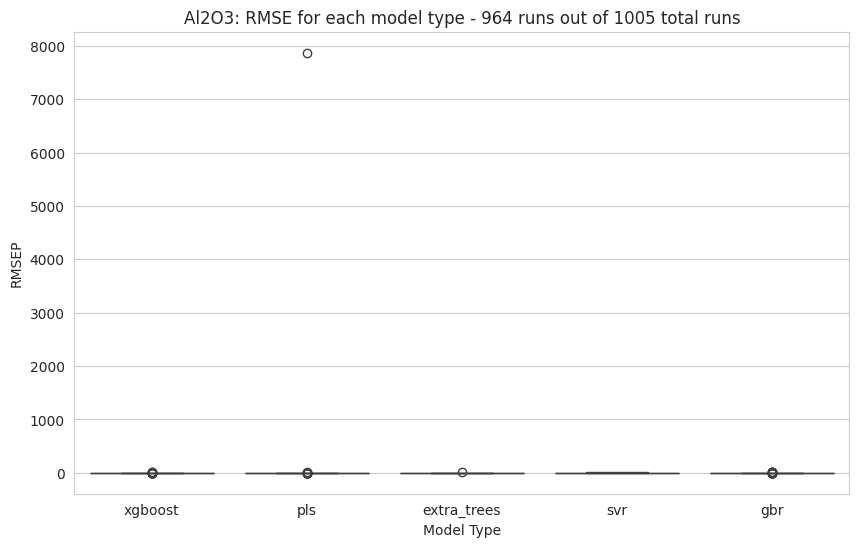

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out runs with 'metrics.rmse_cv' greater than 50
filtered_runs = runs[runs['metrics.rmse_cv'] <= 50]
total_runs = len(runs)

sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.boxplot(x='params.model_type', y='metrics.rmse', data=filtered_runs)
plt.title(f"{oxide}: RMSE for each model type - {len(filtered_runs)} runs out of {total_runs} total runs")
plt.xlabel("Model Type")
plt.ylabel("RMSEP")
plt.show()



In [6]:
# Find the runs that minimize rmse, rmse_cv, std_dev, and std_dev_cv
optimal_runs = filtered_runs.loc[filtered_runs[['metrics.rmse', 'metrics.rmse_cv', 'metrics.std_dev', 'metrics.std_dev_cv']].idxmin()]

# Display the optimal runs
optimal_runs[['metrics.rmse', 'metrics.rmse_cv', 'metrics.std_dev', 'metrics.std_dev_cv', 'params.model_type']]


,metrics.rmse,metrics.rmse_cv,metrics.std_dev,metrics.std_dev_cv,params.model_type
644,1.695846,2.543831,1.693939,2.535500,svr
37,1.740205,2.075363,1.740255,2.067163,xgboost
644,1.695846,2.543831,1.693939,2.535500,svr
37,1.740205,2.075363,1.740255,2.067163,xgboost


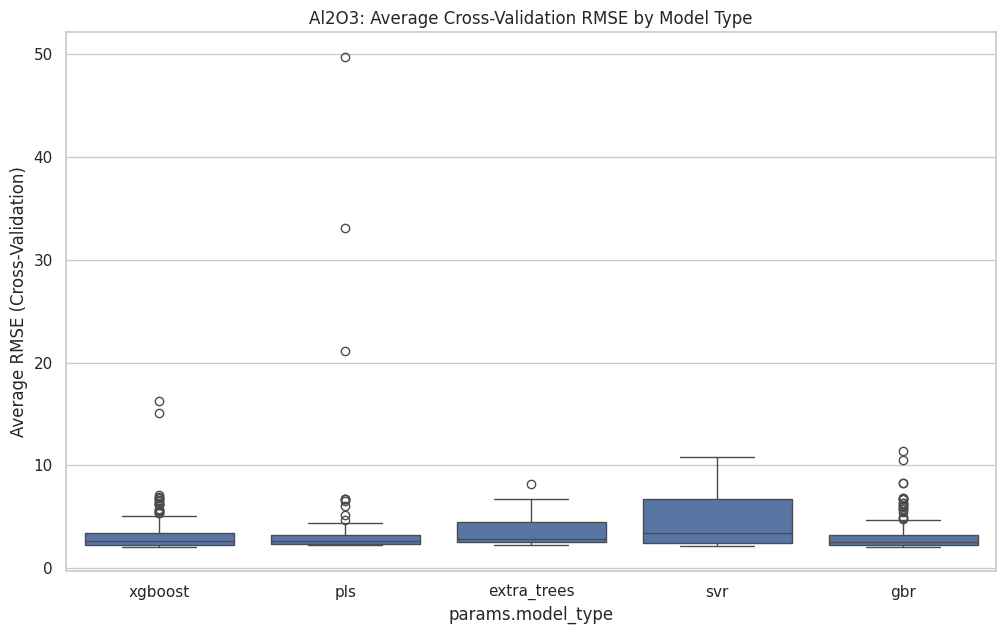

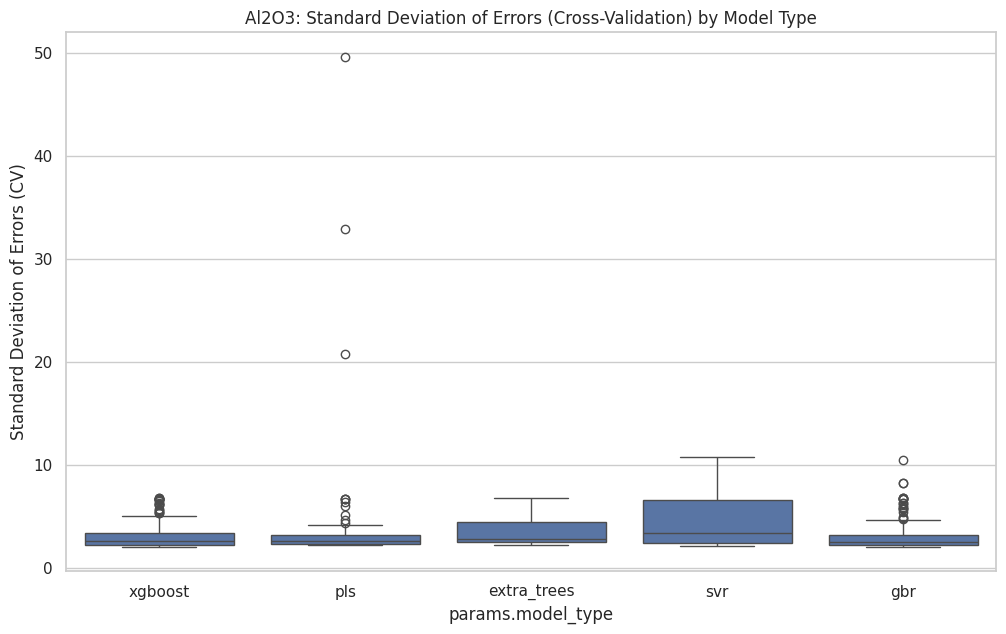

In [7]:
# Setting up visualization style
sns.set(style="whitegrid")

# Plotting RMSE CV
plt.figure(figsize=(12, 7))
sns.boxplot(x='params.model_type', y='metrics.rmse_cv', data=filtered_runs)
plt.title(f'{oxide}: Average Cross-Validation RMSE by Model Type')
plt.ylabel('Average RMSE (Cross-Validation)')
plt.show()

# Plotting Standard Deviation of RMSE CV
plt.figure(figsize=(12, 7))
sns.boxplot(x='params.model_type', y='metrics.std_dev_cv', data=filtered_runs)
plt.title(f'{oxide}: Standard Deviation of Errors (Cross-Validation) by Model Type')
plt.ylabel('Standard Deviation of Errors (CV)')
plt.show()


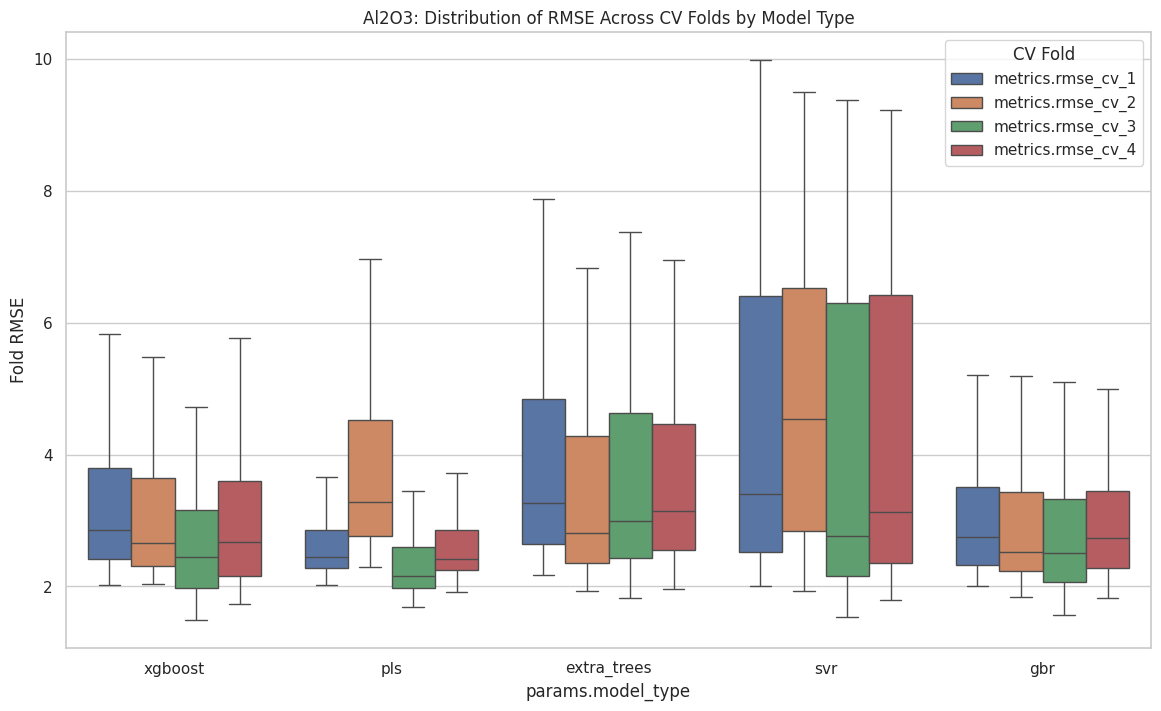

In [8]:
# Prepare a melted DataFrame for seaborn plotting
melted_df = filtered_runs.melt(id_vars=['params.model_type'], value_vars=[f'metrics.rmse_cv_{i+1}' for i in range(n_splits)],
                               var_name='CV Fold', value_name='Fold RMSE')

# Plotting without outliers
plt.figure(figsize=(14, 8))
sns.boxplot(x='params.model_type', y='Fold RMSE', hue='CV Fold', data=melted_df, showfliers=False)
plt.title(f'{oxide}: Distribution of RMSE Across CV Folds by Model Type')
plt.show()


In [9]:
cv_columns = [
    'metrics.rmse_cv', 'params.model_type', 'params.scaler_type',
    'params.transformer_type', 'params.pca_type'
]
filtered_runs = runs[cv_columns]
filtered_runs = filtered_runs[filtered_runs['metrics.rmse_cv'] <= 50]


# Rename columns for clarity
rename_dict = {col: col.split('.')[-1] for col in cv_columns}
filtered_runs = filtered_runs.rename(columns=rename_dict)

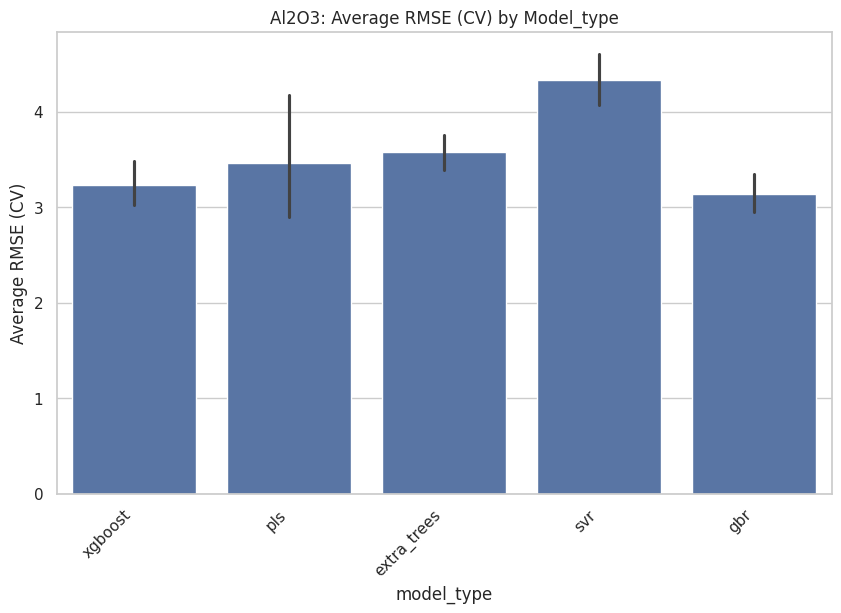

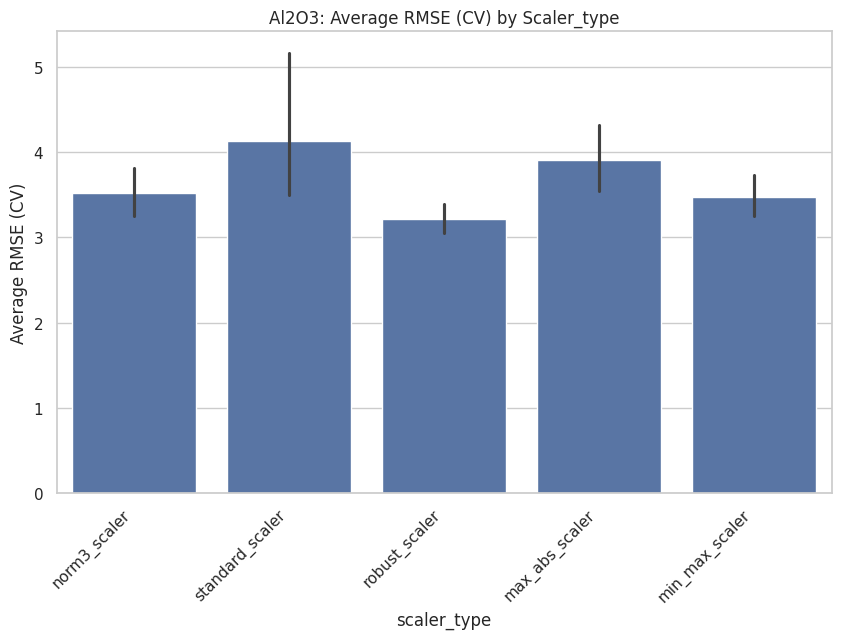

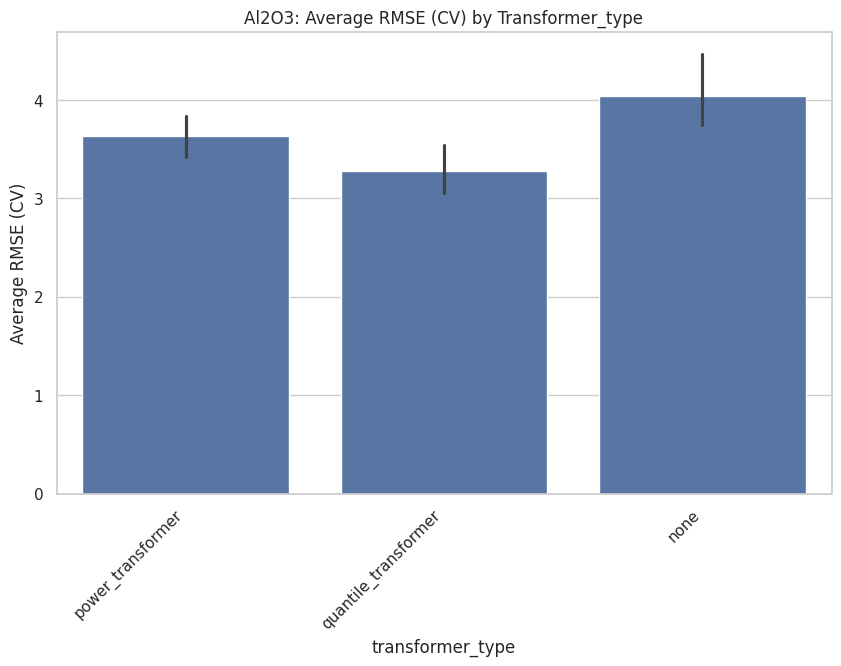

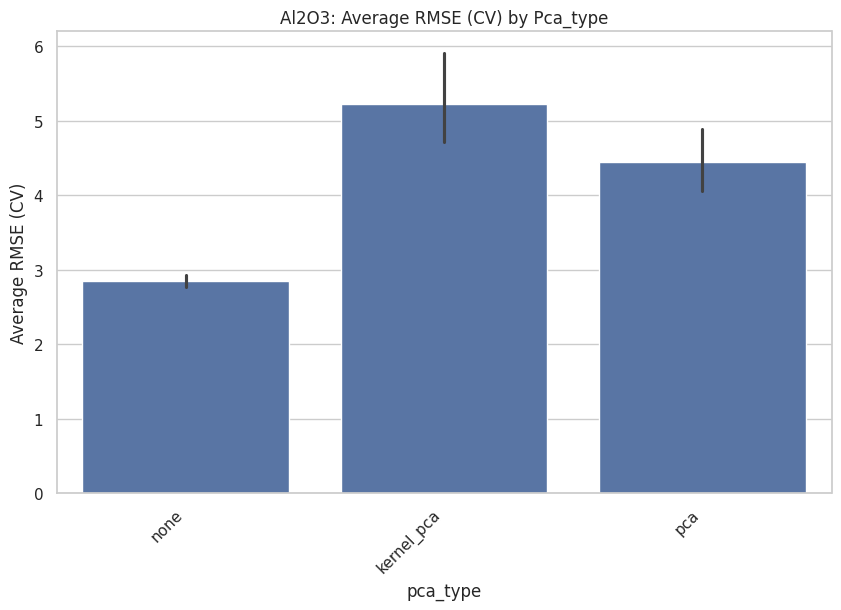

    model_type      scaler_type      transformer_type pca_type   rmse_cv
166    xgboost   max_abs_scaler                  none     none  2.193686
198    xgboost  standard_scaler                  none     none  2.227406
62         gbr     norm3_scaler  quantile_transformer     none  2.242015
79         gbr  standard_scaler  quantile_transformer     none  2.262091
53         gbr   min_max_scaler  quantile_transformer     none  2.319822
50         gbr   min_max_scaler     power_transformer     none  2.327024
45         gbr   max_abs_scaler  quantile_transformer     none  2.331905
195    xgboost    robust_scaler  quantile_transformer     none  2.348213
203    xgboost  standard_scaler  quantile_transformer     none  2.382705
56         gbr     norm3_scaler                  none     none  2.393284


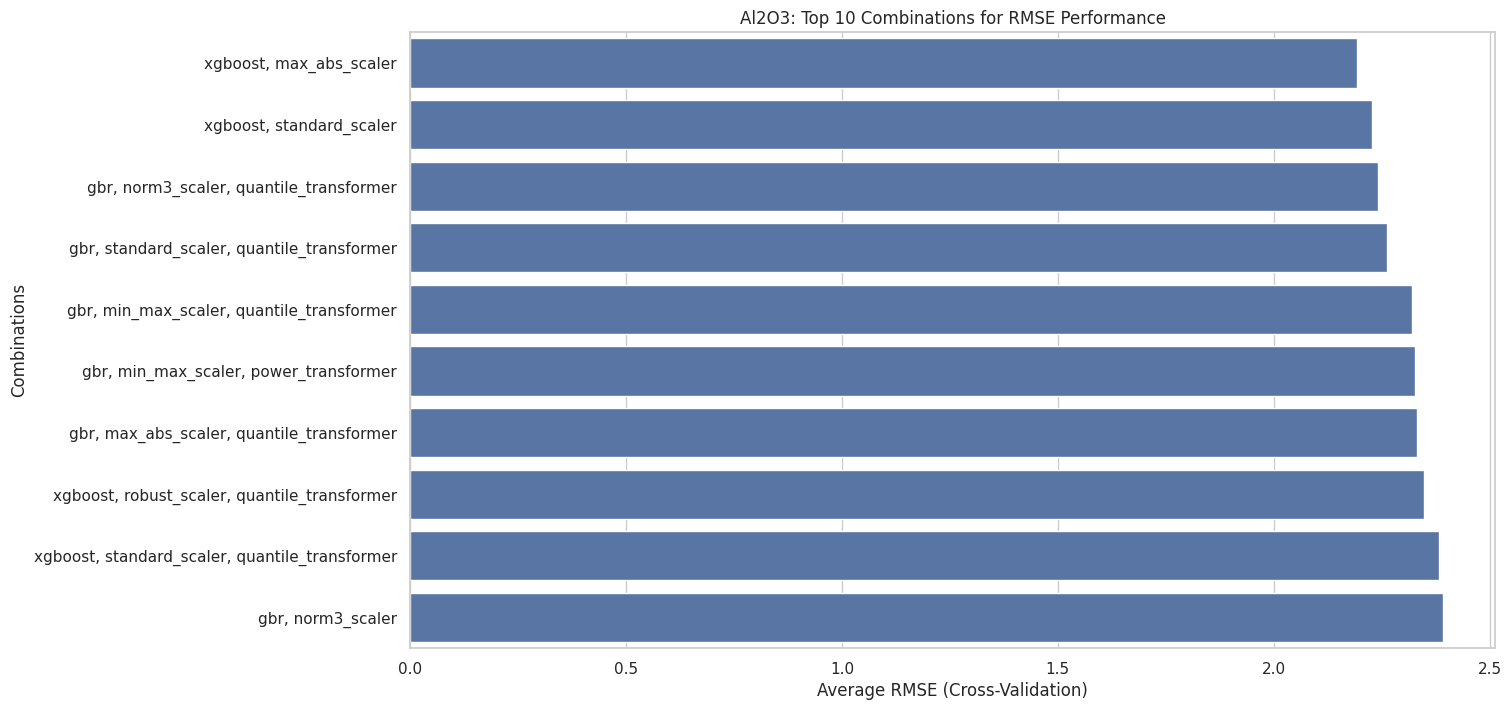

In [10]:
sns.set(style="whitegrid")

# Individual Parameters
for parameter in ['model_type', 'scaler_type', 'transformer_type', 'pca_type']:
    plt.figure(figsize=(10, 6))
    chart = sns.barplot(x=parameter, y='rmse_cv', data=filtered_runs)
    chart.set_xticks(range(len(filtered_runs[parameter].unique())))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title(f'{oxide}: Average RMSE (CV) by {parameter.capitalize()}')
    plt.ylabel('Average RMSE (CV)')
    plt.show()

# Combinations of Parameters
# Considering combinations might result in a lot of categories, focus on the top few based on average RMSE
combination_data = filtered_runs.groupby(['model_type', 'scaler_type', 'transformer_type', 'pca_type']).mean()['rmse_cv']
combination_data = combination_data.reset_index().sort_values(by='rmse_cv', ascending=True)

# Display top 10 combinations
print(combination_data.head(10))

# Optionally, visualize these top combinations
plt.figure(figsize=(14, 8))
combination_data_top10 = combination_data[:10]
combination_labels = combination_data_top10.apply(lambda row: ', '.join([str(row[param]) for param in ['model_type', 'scaler_type', 'transformer_type', 'pca_type'] if row[param] != 'none']), axis=1)
sns.barplot(x='rmse_cv', y=combination_labels, data=combination_data_top10, orient='h')
plt.title(f'{oxide}: Top 10 Combinations for RMSE Performance')
plt.xlabel('Average RMSE (Cross-Validation)')
plt.ylabel('Combinations')
plt.show()

In [11]:
# Aggregate the data to compute mean and standard deviation of RMSE for each configuration
# Lower RMSE (lower is better) and lower STD RMSE (lower is better for consistency)
aggregated_data = filtered_runs.groupby(['model_type', 'scaler_type', 'transformer_type', 'pca_type']).agg({
    'rmse_cv': ['mean', 'std']
}).reset_index()

# Flatten the columns (multi-level index after aggregation)
aggregated_data.columns = ['Model Type', 'Scaler Type', 'Transformer Type', 'PCA Type', 'Mean RMSE', 'STD RMSE']

# Sort configurations first by mean RMSE (ascending, lower is better) and then by STD RMSE (ascending, lower is better for consistency)
sorted_data = aggregated_data.sort_values(by=['Mean RMSE', 'STD RMSE'], ascending=[True, True])

# Display the top 10 consistently good configurations
print(sorted_data.head(10))

    Model Type      Scaler Type      Transformer Type PCA Type  Mean RMSE  \
166    xgboost   max_abs_scaler                  none     none   2.193686   
198    xgboost  standard_scaler                  none     none   2.227406   
62         gbr     norm3_scaler  quantile_transformer     none   2.242015   
79         gbr  standard_scaler  quantile_transformer     none   2.262091   
53         gbr   min_max_scaler  quantile_transformer     none   2.319822   
50         gbr   min_max_scaler     power_transformer     none   2.327024   
45         gbr   max_abs_scaler  quantile_transformer     none   2.331905   
195    xgboost    robust_scaler  quantile_transformer     none   2.348213   
203    xgboost  standard_scaler  quantile_transformer     none   2.382705   
56         gbr     norm3_scaler                  none     none   2.393284   

     STD RMSE  
166  0.138343  
198  0.012515  
62   0.059286  
79   0.077037  
53   0.229358  
50   0.161695  
45   0.125154  
195  0.338286  
203  0.0

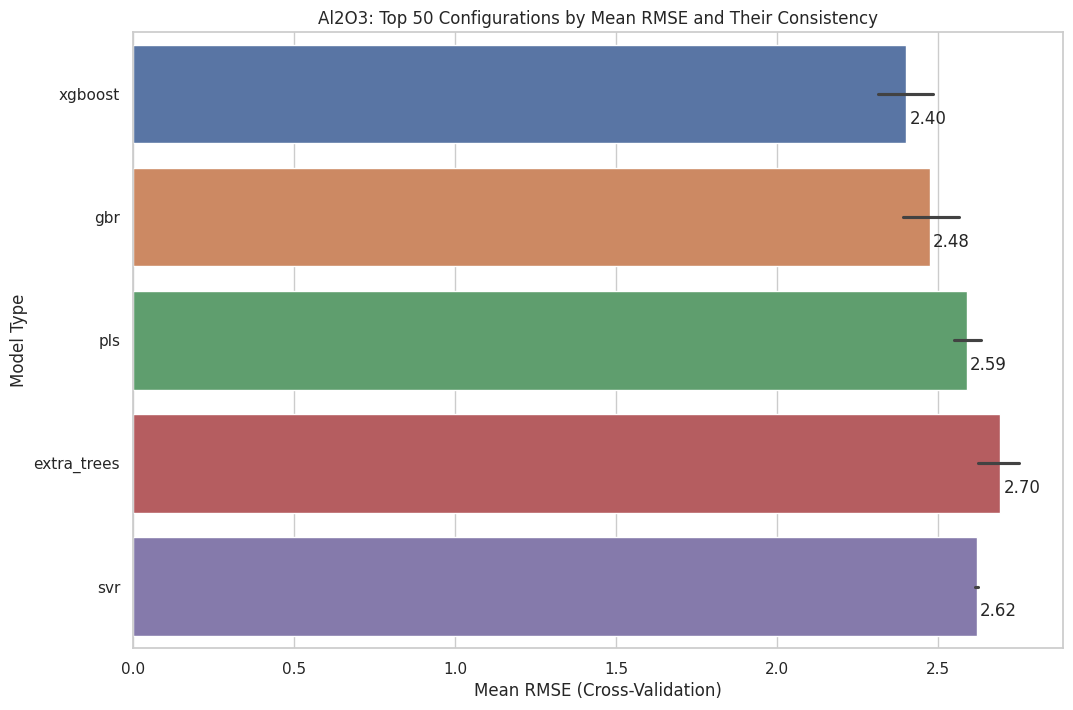

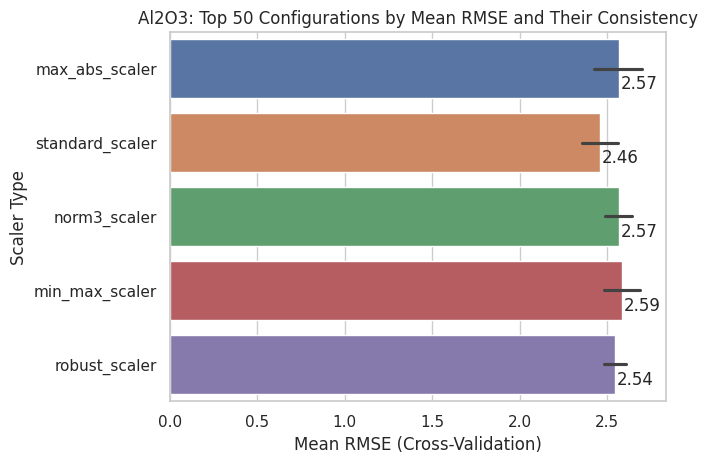

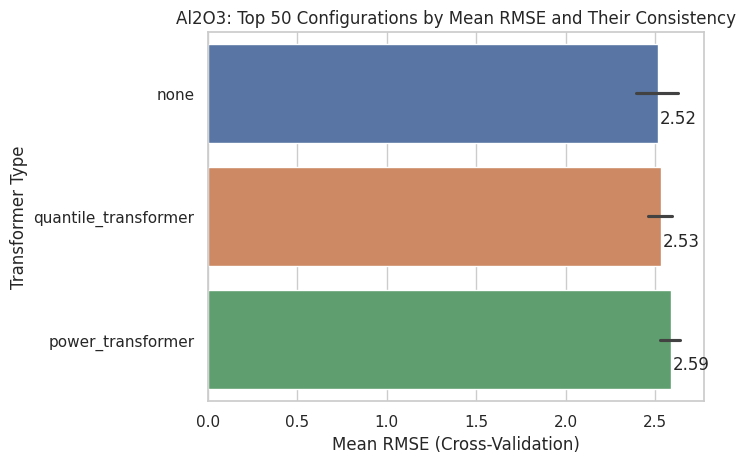

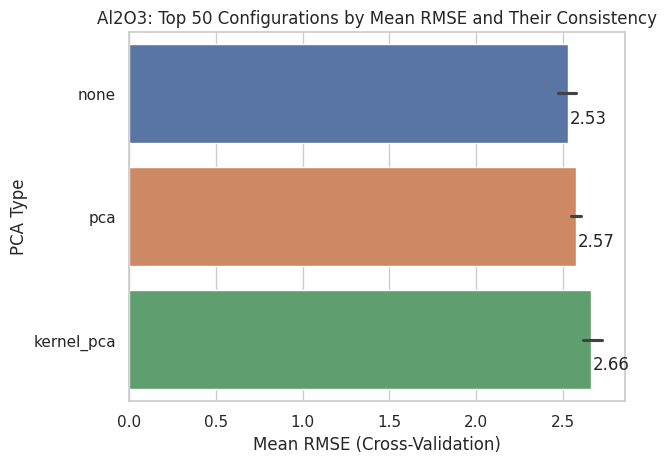

In [12]:
sns.set(style="whitegrid")

# Plotting the top configurations based on Mean RMSE
plt.figure(figsize=(12, 8))
top_n = 50
for parameter in ['Model Type', 'Scaler Type', 'Transformer Type', 'PCA Type']:
    top_configurations = sns.barplot(x='Mean RMSE', y=parameter, hue=parameter, data=sorted_data.head(top_n), dodge=False)
    plt.title(f'{oxide}: Top {top_n} Configurations by Mean RMSE and Their Consistency')
    plt.xlabel('Mean RMSE (Cross-Validation)')
    plt.ylabel(parameter)
    # Annotate each bar with the value of Mean RMSE
    for p in top_configurations.patches:
        width = p.get_width()
        plt.text(width + 0.01, p.get_y()+0.2 + p.get_height() / 2, f'{width:.2f}', ha='left', va='center')
    plt.show()
